# Deep Learning course 2022-2023
## Project: Video Prediction on Moving MNIST
### Project Contributors
* Mattia Castelmare, 1815675
* Andrea Giuseppe Di Francesco, 1836928
* Enrico Fazzi, 2003876

#### Installation cells

In [ ]:
# !git clone https://github.com/tychovdo/MovingMNIST.git
# !pip3 install pytorch-lightning==1.5.10
# !pip3 install torchvision
# !pip3 install matplotlib
# !pip install wandb

### Importing Libraries

In [1]:
### wandb codes ###
from MovingMNIST.MovingMNIST import *
import wandb
#####################

import torch
import os
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import Trainer
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Useful Functions

In [2]:
def show_video(tensor):
    ''' This function display a video, given a torch tensor (source: https://stackoverflow.com/questions/67261108/how-to-display-a-video-in-colab-using-a-pytorch-tensor-of-rgb-image-arrays)
        INPUT: tensor (Frames x Channels x Height x Width) 
        OUTPUT: Display an animation '''

    fig, ax = plt.subplots()

    imgs = tensor
    imgs = imgs.permute(0, 2, 3, 1)  # Permuting to (Bx)HxWxC format
    frames = [[ax.imshow(imgs[i], cmap='gray')] for i in range(len(imgs))]

    ani = animation.ArtistAnimation(fig, frames)
    return ani


def collate(batch):
    ''' This function is used within the Dataloader pytorch utility. 
        INPUT: batch: List of tuples of tensor, each tuple contains the input video and the target video, 
        OUTPUT: A tuple (input, gt), s.t. both of them has dimension (B x T x C x H x W)'''

    list_tuples = list(map(lambda x: (torch.reshape(x[0], (1, x[0].shape[0], 1, x[0].shape[1], x[0].shape[2])), torch.reshape(
        x[1], (1, x[1].shape[0], 1, x[1].shape[1], x[1].shape[2]))), batch))

    input = list_tuples[0][0]
    gt = list_tuples[0][1]

    for i in range(1, len(list_tuples)):
        input = torch.cat((input, list_tuples[i][0]), dim=0)
        gt = torch.cat((gt, list_tuples[i][1]), dim=0)

    return ((input/255).type(torch.FloatTensor), (gt/255).type(torch.FloatTensor))


def save_model(model, loss, path):
  # This function is a customized in order to save a pytorch model.
    checkpoint = {'model_state': model.state_dict(),
                  'loss': loss}
    torch.save(checkpoint, path)


def load_model(path, model):
  # This function loads a pytorch model from a path.
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state'])

    return checkpoint


def kronecker_product2(dyn, static):

    out = torch.zeros(static.shape, device = str(static.device))
    for i in range(out.shape[0]):

        r = torch.stack([torch.kron(ai, bi)
                        for ai, bi in zip(dyn[i], static[i])], dim=0)
        out[i, :, :, :] = r
    return out


def kronecker_product(dyn, static):
    """ This function is a fast implementation of the kronocker product mentioned in the paper https://arxiv.org/pdf/2206.12126.pdf.
        The original implementation, from which we took inspiration is available at https://gist.github.com/yulkang/4a597bcc5e9ccf8c7291f8ecb776382d.
        INPUTs:
            -dyn: results of the dynamical attention module: (B, T*C, 1, 1),
            -static: results of the static attention module: (B, T*C, 32, 32).
        OUTPUTs:
            - res: Kronocker product result.
    """

    siz1 = torch.Size(torch.tensor(dyn.shape[-2:]) * torch.tensor(static.shape[-2:]))
    res = dyn.unsqueeze(-1).unsqueeze(-3) * static.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)


### Useful variables 

In [4]:
t1 = torch.randn((16, 10, 1, 1), device = 0)
t2 = torch.randn((16, 10, 32, 32), device = 0)

In [6]:
# print(torch.mean(r))
# print(torch.mean(r2))

r = kronecker_product(t1, t2)
r2 = kronecker_product2(t1, t2)




In [7]:
torch.equal(r, r2)

True

In [3]:
shuffle_train = True
shuffle_test = False
download = False

### wandb codes ###
wb = True
project_name = "VP_on_MMNIST"
if wb:
    wandb.login()
###################

SEED = 2812023
pl.seed_everything(SEED)

root = './data'
if not os.path.exists(root):
    os.mkdir(root)


wandb: Currently logged in as: difra00 (deepl_wizards). Use `wandb login --relogin` to force relogin
Global seed set to 2812023


### Pytorch lightning DataModule:
* Set the MMNIST Dataset object and Dataloader 

In [4]:
class pl_Dataset(pl.LightningDataModule):

    def __init__(self, batch_size):

        self.bs = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_set = MovingMNIST(root=root,
                                         train=True,
                                         download=download)
        elif stage == 'test':
            self.test_set = MovingMNIST(root=root,
                                        train=False,
                                        download=download)

    def train_dataloader(self, *args, **kwargs):

        train_loader = torch.utils.data.DataLoader(
            dataset=self.train_set,
            batch_size=self.bs,
            shuffle=shuffle_train,
            collate_fn=collate)

        return train_loader

    def val_dataloader(self, *args, **kwargs):

        test_loader = torch.utils.data.DataLoader(
            dataset=self.test_set,
            batch_size=self.bs,
            shuffle=shuffle_test,
            collate_fn=collate)

        return test_loader


### Hyperparameters

In [48]:


batch_size = 64
lr = 1e-2
wd = 5e-2

tau = 1e-1  # KL Divergency parameter


### Vanilla hyperparameters ###

hyperparametersS = {'lr': lr,
                       'wd': wd,
                       'epochs': 1000,
                       'batch_size': batch_size,
                       'CNN': {'input': 1,
                               'hidden_S': 64,  # Output channels in Encoder / Input channel in Decoder
                               'output_T': 512,  # Output channels in Inception, Hidden C. == Output channels // 2
                               'ksize': 3,
                               'Ns': 4,
                               'Nt': 3}
                       }

hyperparametersT = {'lr': lr,
                       'wd': wd,
                       'epochs': 100,
                       'batch_size': batch_size,
                       'CNN': {'input': 1,
                               'hidden_S': 64,
                               'ksize': 3
                              },
                        'n_layers': 4    
                    }


data = pl_Dataset(batch_size)

data.setup(stage='fit')
data.setup(stage='test')


# Models

### Our VanillaED (Enry and Matty)
* Implementation of a Vanilla Encoder Decoder architecture with a skip connection

In [49]:
class VEncoder(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, n_layers):
        super(VEncoder, self).__init__()
        self.conv_layers = []

        for i in range(n_layers//2):
            if i == 0:
                self.conv_layers.append(nn.Conv2d(in_channels=input_channels, out_channels=output_channels,
                                kernel_size=kernel_size, padding='same'))
                self.conv_layers.append(nn.ReLU(inplace = True))
            else:
                self.conv_layers.append(nn.Conv2d(in_channels=output_channels, out_channels=output_channels,
                                kernel_size=kernel_size, padding='same'))
                self.conv_layers.append(nn.ReLU(inplace = True))
                
                
        self.conv_layers.append(nn.MaxPool2d(2))
        
        for i in range(n_layers//2):
            self.conv_layers.append(nn.Conv2d(in_channels=output_channels, out_channels=output_channels,
                              kernel_size=kernel_size, padding='same'))
            self.conv_layers.append(nn.ReLU(inplace = True))
            


        self.enc = nn.Sequential(*self.conv_layers)

    def forward(self, input):
        skip = self.enc[0](input)
        return self.enc(input), skip


class VDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, n_layers):
        super(VDecoder, self).__init__()

        self.trans_conv_layers = []

        for i in range(n_layers//2):
            if i == n_layers//2 - 1:
                self.trans_conv_layers.append(nn.Conv2d(in_channels=input_channels, out_channels=input_channels,
                                kernel_size=kernel_size, padding = 'same'))
                self.trans_conv_layers.append(nn.ReLU(inplace = True))
                
            else:
                self.trans_conv_layers.append(nn.Conv2d(in_channels=input_channels, out_channels=input_channels,
                                kernel_size=kernel_size, padding = 'same'))
                self.trans_conv_layers.append(nn.ReLU(inplace = True))
                
                
        
        
        for i in range(n_layers//2 -1):
            self.trans_conv_layers.append(nn.ConvTranspose2d(in_channels=input_channels, out_channels=input_channels,
                                kernel_size=kernel_size, stride = 2, padding = 1, output_padding = 1))
            self.trans_conv_layers.append(nn.ReLU(inplace = True))
            
        self.dec = nn.Sequential(*self.trans_conv_layers)

    def forward(self, input):
        
        out = self.dec(input)
        
        return out


class VEncoderDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, n_layers = 4):
        super(VEncoderDecoder, self).__init__()

        self.encoder = VEncoder(input_channels=input_channels, output_channels=output_channels,
                                kernel_size=kernel_size, n_layers=n_layers)
        self.decoder = VDecoder(input_channels=output_channels, output_channels=input_channels, kernel_size=kernel_size,
                                n_layers=n_layers)

        self.num_layers = n_layers

        self.final = nn.Conv2d(in_channels=2*output_channels, out_channels=input_channels, kernel_size=kernel_size, padding = 'same')

    def forward(self, input):
        B, T, C, H, W = input.shape
        input = input.reshape((B*T, C, H, W))
        output, skip = self.encoder(input)
        output = self.decoder(output)
        
        output = torch.cat((skip, output), dim = 1)
        output = self.final(output)

        output = output.reshape((B, T, C, H, W))

        return output


#### SimVP
* Implementation of the SimVP architecture, the details are available at https://arxiv.org/pdf/2206.05099.pdf,
* Encoder (CNN) +  Translator (Inception) + Decoder (CNN) 
* The implementation details were taken by the original implementation https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction , since some of them were neglected in the paper.

In [50]:
# Some of the following functions are inspired by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction.

def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse:
        return list(reversed(strides[:N]))
    else:
        return strides[:N]


class ConvBlock(nn.Module):

    def __init__(self, inputC, outputC, stride=None, padding='same', transpose=False, groups=8, kernel=hyperparametersS['CNN']['ksize']):
        super(ConvBlock, self).__init__()
        if inputC % groups != 0:
            groups = 1
        if not transpose:
            self.conv = nn.Conv2d(
                inputC, outputC, kernel_size=kernel, padding=padding, stride=stride, groups=groups)
        else:
            self.conv = nn.ConvTranspose2d(
                inputC, outputC, kernel, stride=stride, padding=1, output_padding=stride // 2)

        self.layernorm = nn.GroupNorm(groups, outputC)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):

        x = self.leaky(self.layernorm(self.conv(x)))

        return x


class EncoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(EncoderSimVP, self).__init__()
        strides = stride_generator(n_layers)
        layers = [ConvBlock(hyperparametersS['CNN']['input'], hyperparametersS['CNN']
                            ['hidden_S'], groups=2, stride=strides[0], padding=1)]

        for layer in range(1, n_layers):
            stride = strides[layer]
            layers.append(ConvBlock(
                hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['hidden_S'], groups=2, stride=stride, padding=1))

        self.enc = nn.Sequential(*layers)

    def forward(self, x):

        B, T, C, H, W = x.shape

        x = x.reshape((B*T, C, H, W))

        skip = self.enc[0](x)
        x = self.enc(x)

        # x = x.reshape((B, T, hyperparameters['CNN']['hidden_S'], H, W))

        return x, skip


class DecoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(DecoderSimVP, self).__init__()
        strides = stride_generator(n_layers, reverse=True)
        layers = []
        for layer in range(n_layers-1):
            stride = strides[layer]
            layers.append(ConvBlock(hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                          ['hidden_S'], transpose=True, groups=2, stride=stride, padding=1))

        layers.append(ConvBlock(2*hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                      ['hidden_S'], transpose=True, groups=2, stride=strides[-1], padding=1))

        self.proj = nn.Conv2d(
            hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['input'], 1)

        self.dec = nn.Sequential(*layers)

    def forward(self, x, skip):

        for l_idx in range(len(self.dec)-1):
            x = self.dec[l_idx](x)

        x = self.dec[-1](torch.cat((x, skip), dim=1))
        x = self.proj(x)

        return x


class InceptionModule(nn.Module):

    def __init__(self, inputC, outputC, kernel_list=[3, 5, 7, 11], groups=8):
        super(InceptionModule, self).__init__()

        hiddenC = outputC // 2

        self.Conv = nn.Conv2d(
            inputC, hiddenC, kernel_size=1, stride=1, padding=0)

        layers = []

        for kernel in kernel_list:
            layers.append(ConvBlock(hiddenC, outputC, groups=4,
                          stride=1, padding=kernel // 2, kernel=kernel))

        self.ConvParallel = nn.Sequential(*layers)

    def forward(self, input):

        x = self.Conv(input)

        output = 0

        for conv in self.ConvParallel:

            output += conv(x)

        return output


class Translator(nn.Module):

    def __init__(self, n_layers, inputC):
        super(Translator, self).__init__()

        self.n_layers = n_layers
        enc_layers = [InceptionModule(
            inputC, hyperparametersS['CNN']['output_T'])]

        for inc_layer in range(n_layers-1):
            enc_layers.append(InceptionModule(
                hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))

        enc_layers.append(InceptionModule(
            hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))

        self.encoder = nn.Sequential(*enc_layers)

        dec_layers = [InceptionModule(
            hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T'])]

        for inc_layers in range(n_layers-1):
            dec_layers.append(InceptionModule(
                2*hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))
        dec_layers.append(InceptionModule(
            2*hyperparametersS['CNN']['output_T'], inputC))

        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, input):
        B, T, C, H, W = input.shape
        input = input.reshape((B, T*C, H, W))

        enc_feat = []
        mid_feat = input

        for encoder_layer in self.encoder:
            mid_feat = encoder_layer(mid_feat)
            enc_feat.append(mid_feat)

        output = self.decoder[0](mid_feat)

        for l_idx in range(1, self.n_layers+1):

            input = torch.cat((output, enc_feat[-l_idx]), dim=1)
            output = self.decoder[l_idx](input)

        output = output.reshape((B, T, C, H, W))

        return output


class SimVP(nn.Module):
    def __init__(self):
        super(SimVP, self).__init__()

        self.encoder = EncoderSimVP(hyperparametersS['CNN']['Ns'])
        self.translator = Translator(
            hyperparametersS['CNN']['Nt'], 10*hyperparametersS['CNN']['hidden_S'])
        self.decoder = DecoderSimVP(hyperparametersS['CNN']['Ns'])

    def forward(self, input):
        B, T, C, H, W = input.shape

        output, skip = self.encoder(input)
        _, C_, H_, W_ = output.shape
        output = output.view(B, T, C_, H_, W_)

        output = self.translator(output)

        output = output.reshape((B*T, C_, H_, W_))

        Y = self.decoder(output, skip)

        Y = Y.reshape((B, T, C, H, W))

        return Y


#### Ground Truth

In [51]:
import torch
from torch import nn


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if not transpose:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=stride // 2)
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, groups=groups)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3, 5, 7, 11], groups=8):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker,
                          stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y


def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse:
        return list(reversed(strides[:N]))
    else:
        return strides[:N]


class Encoder(nn.Module):
    def __init__(self, C_in, C_hid, N_S):
        super(Encoder, self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )

    def forward(self, x):  # B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)

        return latent, enc1


class Decoder(nn.Module):
    def __init__(self, C_hid, C_out, N_S):
        super(Decoder, self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True)
              for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0, len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y


class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker=[3, 5, 7, 11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(
            channel_in, channel_hid//2, channel_hid, incep_ker=incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(
                channel_hid, channel_hid//2, channel_hid, incep_ker=incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid //
                          2, channel_hid, incep_ker=incep_ker, groups=groups))

        dec_layers = [Inception(
            channel_hid, channel_hid//2, channel_hid, incep_ker=incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(
                2*channel_hid, channel_hid//2, channel_hid, incep_ker=incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid //
                          2, channel_in, incep_ker=incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=64, hid_T=256, N_S=4, N_T=8, incep_ker=[3, 5, 7, 11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)

    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y


### TAU Module
* Implementation of th Temporal Attention Unit architecture

In [58]:
class Dyn_attention(nn.Module):
    def __init__(self, input_ftrs, dim, hidden_dim, n_layers, hidden_act=True): 
        super(Dyn_attention, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        excitation_list = []

        for layer in range(n_layers):
            excitation_list.append(nn.Linear(input_ftrs, hidden_dim, bias=False))
            excitation_list.append(nn.ReLU(inplace=True))
            excitation_list.append(nn.Linear(hidden_dim, input_ftrs, bias=False))
            excitation_list.append(nn.Sigmoid())


        self.MLP = nn.Sequential(*excitation_list)


    def forward(self, H):
        x = self.avg_pool(H)
        B, TC, _, _ = x.shape

        x = x.view(B, -1)

        x = self.MLP(x).view(B, TC, 1, 1)

        return x
    

class Static_attention(nn.Module):
    def __init__(self, input_shape, small_kern, dilatation, n_layers):
        super(Static_attention, self).__init__()
        
        TC, H, W = input_shape

        conv_layers = []
        for i in range(n_layers):
            conv_layers.append(nn.Conv2d(
                in_channels=TC, out_channels=TC, kernel_size=small_kern, padding='same'))
            conv_layers.append(nn.Conv2d(
                in_channels=TC, out_channels=TC, kernel_size=small_kern, padding='same', dilation=dilatation))
            conv_layers.append(
                nn.Conv2d(in_channels=TC, out_channels=TC, kernel_size=1, padding='same'))

        self.static_net = nn.Sequential(*conv_layers)

    def forward(self, x):
        
        x = self.static_net(x)
        
        return x


class TAU(nn.Module):
    def __init__(self, input_shape, small_kern, dilatation):
        super(TAU, self).__init__()

        input = torch.randn(input_shape, device = 'cuda' if torch.cuda.is_available() else 'cpu')
        self.avg_pool = nn.AvgPool2d(kernel_size = (input_shape[-1], input_shape[-2]))

        with torch.no_grad():
            test = self.avg_pool(input)
            flat = F.torch.flatten(test)
            input_ftrs = flat.shape[0]

        n_s_layers = 1
        n_d_layers = 1 

        self.DA_module = Dyn_attention(
            input_ftrs=input_ftrs, dim = (input_shape[-1], input_shape[-2]), hidden_dim = input_ftrs // 16, n_layers=n_d_layers, hidden_act=True)
        self.SA_module = Static_attention(
            input_shape=input_shape, small_kern=small_kern, dilatation=dilatation, n_layers=n_s_layers)

    def forward(self, H):
        dynamic = self.DA_module(H)
        static = self.SA_module(H)
        res = kronecker_product(dynamic, static)
        res = res * H
        return res

class TAUNet(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, n_layers = 4):
        super(TAUNet, self).__init__()

        self.encoder = VEncoder(input_channels=input_channels, output_channels=output_channels,
                                kernel_size=kernel_size, n_layers=n_layers)
        self.decoder = VDecoder(input_channels=output_channels, output_channels=input_channels, kernel_size=kernel_size,
                                n_layers=n_layers)
        # self.encoder = EncoderSimVP(hyperparametersS['CNN']['Ns'])
        # self.decoder = DecoderSimVP(hyperparametersS['CNN']['Ns'])

        input_shape = (10*output_channels, 32, 32)
        
        self.tau = TAU(input_shape, kernel_size, dilatation = 1)

        self.num_layers = n_layers

        self.final = nn.Conv2d(in_channels=2*output_channels, out_channels=input_channels, kernel_size=kernel_size, padding = 'same')

    def forward(self, input):
        B, T, C, H, W = input.shape
        input = input.reshape((B*T, C, H, W))
        output, skip = self.encoder(input)

        BT, C_, H_, W_ = output.shape

        output = output.reshape((B, T, C_, H_, W_))
        output = output.reshape((B, T*C_, H_, W_))

        output = self.tau(output)


        output = output.reshape((B, T, C_, H_, W_))
        output = output.reshape((B*T, C_, H_, W_))

        output = self.decoder(output)
        
        output = torch.cat((skip, output), dim = 1)
        output = self.final(output)

        output = output.reshape((B, T, C, H, W))
        
        

        return output



# PROVA

In [54]:
class MSE_loss(nn.Module):
    ''' This class resembles the mean squared error so as defined in the evaluation for the video prediction task. '''
    def __init__(self):
        super(MSE_loss, self).__init__()
        self.loss = nn.MSELoss(reduction = 'sum')

    def forward(self, pred, true):
        B, T, C, H , W = pred.shape

        pred = pred.reshape((B*T, C, H, W))
        true = true.reshape((B*T, C, H, W))
        loss = []

        for i in range(pred.shape[0]):
            inter_loss = self.loss(pred[i], true[i])
            # print(inter_loss)
            loss.append(inter_loss)

        # print("the value is: \n",torch.min(pred).item())
        # print("the value is: \n",torch.max(pred).item())

        # print(torch.min(true/255))


        tot_loss = sum(loss)/len(loss)

       

        return tot_loss

class plTrainingModule(pl.LightningModule):

    def __init__(self, model, model_conf, path = None, save = False, load = False):
        super(plTrainingModule, self).__init__()
        self.model = model
        self.mc = model_conf
        self.save = save
        self.load = load
        self.dest_path = path

        self.MSE = MSE_loss()
        if self.mc == 'tau':
            self.KL = nn.KLDivLoss()
        
        self.KL_list = []
        self.tot_loss_tr = []
        self.tot_loss = []
        self.mse_list = []

        if self.load:
            load_model(self.dest_path, self.model)
            

    def training_step(self, batch, batch_idx):

        ground_truth = batch[1]

        ### OUTPUT COMPUTATION ###
 

        prediction = self.model(batch[0])
        mse = self.MSE(prediction, ground_truth)

        loss = mse  
      


        if self.mc == 'tau':
            KL_Loss = self.compute_KLloss(prediction, ground_truth)
            # print(KL_Loss.item())
            loss += KL_Loss


        self.tot_loss_tr.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):

        ground_truth = batch[1]

        ### OUTPUT COMPUTATION ###

        prediction = self.model(batch[0])
        mse = self.MSE(prediction, ground_truth)

        loss = mse  

        if self.mc == 'tau':
            KL_Loss = self.compute_KLloss(prediction, ground_truth)
            loss += KL_Loss
            self.KL_list.append(KL_Loss.item())


        self.tot_loss.append(loss.item())
        
        self.mse_list.append(mse.item())

        return loss

    def compute_KLloss(self, predicted, ground_truth):
        loss = []
        B, T, C, H, W = predicted.shape
        B, T, C, H, W = ground_truth.shape


        pred = predicted.reshape((B*T, C, H, W))
        ground = ground_truth.reshape((B*T, C, H, W))


        delta_pred = (pred[1:] - pred[:-1])/tau
        delta_gt = (ground[1:] - ground[:-1])/tau

        # 3 is the channel-related dimension
        soft_pred = F.softmax(delta_pred, dim=3)
        # 3 is the channel-related dimension
        soft_gt = F.softmax(delta_gt, dim=3)

        KL_Loss = self.KL(delta_pred, delta_gt)
        loss.append(KL_Loss)
        tot_loss = sum(loss)/len(loss)

        return KL_Loss

    def on_epoch_end(self):
        if len(self.tot_loss_tr) != 0:
            loss_train_mean = sum(self.tot_loss_tr)/len(self.tot_loss_tr)
            loss_mean = sum(self.tot_loss)/len(self.tot_loss)
            
            mse_mean = sum(self.mse_list)/len(self.mse_list)

            self.log(name='TOT. Loss on train', value=loss_train_mean)
            self.log(name='TOT. Loss on test', value=loss_mean)
            self.log(name='MSE loss on test', value=mse_mean)
            
            if self.mc == 'tau':
                KL_mean = sum(self.KL_list)/len(self.KL_list)
                self.log(name = 'KL loss on test', value = KL_mean)
                self.KL_list = []
            self.tot_loss_tr = []
            self.tot_loss = []
            self.mse_list = []


            if self.save:

                save_model(self.model, loss_mean, self.dest_path)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr, weight_decay=wd)


In [55]:
num_gpu = 1 if torch.cuda.is_available() else 0




save = False
load = False


model_conf = 'tau'

if model_conf == 'tau' or model_conf == 'random':
    hyperparameters = hyperparametersT
elif model_conf == 'simvp':
    hyperparameters = hyperparametersS

exp_name = model_conf + '_' + \
    str(hyperparameters['epochs']) + '_' + str(batch_size)

path = exp_name + '.pt'


In [56]:
# SimVP((10, 1, 64, 64), hid_S = 64, hid_T = 512, N_S = 4, N_T = 3)# #TAUNet(hyperparameters['CNN']['input'], hyperparameters['CNN']['hidden_S'], hyperparameters['CNN']['ksize'], hyperparameters['n_layers'])


if model_conf == 'tau':
    model = TAUNet(hyperparameters['CNN']['input'], hyperparameters['CNN']['hidden_S'], hyperparameters['CNN']['ksize'], hyperparameters['n_layers'])
elif model_conf == 'random':
    model = VEncoderDecoder(hyperparameters['CNN']['input'], hyperparameters['CNN']['hidden_S'], hyperparameters['CNN']['ksize'])
elif model_conf == 'simvp':
    model = SimVP()


pl_training_MDL = plTrainingModule(model, model_conf, path, save = save, load = load)


### WANDB CODE ###
if wb:

    wandb_logger = WandbLogger(
        project=project_name, name=exp_name, config=hyperparameters, entity='deepl_wizards')
    trainer = pl.Trainer(
        max_epochs=hyperparameters['epochs'],  # maximum number of epochs.
        gpus=num_gpu,  # the number of gpus we have at our disposal.
        # , overfit_batches = 1
        default_root_dir="", logger=wandb_logger, callbacks=[TQDMProgressBar(refresh_rate=20)]
    )

else:
    trainer = pl.Trainer(
        max_epochs=hyperparameters['epochs'],  # maximum number of epochs.
        gpus=num_gpu,  # the number of gpus we have at our disposal.
        default_root_dir="", callbacks=[TQDMProgressBar(refresh_rate=20)]
    )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [57]:
trainer.fit(model=pl_training_MDL, datamodule=data)

# WANDB code
wandb.finish()


/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | TAUNet    | 8.1 M 
1 | MSE   | MSE_loss  | 0     
2 | KL    | KLDivLoss | 0     
------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.236    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Global seed set to 2812023
/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  89%|████████▉ | 140/157 [00:38<00:04,  3.68it/s, loss=165]   

Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s, loss=164, v_num=txtn]          

/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 6:  25%|██▌       | 40/157 [00:11<00:32,  3.59it/s, loss=164, v_num=txtn] 

/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


KL loss on test,▁█████
MSE loss on test,█▁▁▁▁▁
TOT. Loss on test,█▁▁▁▁▁
TOT. Loss on train,█▁▁▁▁▁
epoch,▁▂▄▅▇█
trainer/global_step,▁▂▄▅▇█
KL loss on test,0.63115
MSE loss on test,163.78154
TOT. Loss on test,163.78154
TOT. Loss on train,163.5656
epoch,5


Epoch 6:  25%|██▌       | 40/157 [00:24<01:13,  1.60it/s, loss=164, v_num=txtn]

In [68]:
loss = MSE_loss()
loss_list = []
c = 0
model.to('cuda')

for batch in data.val_dataloader():
    if c == 1:
        break
    input = batch[0].to('cuda')
    gt = batch[1].to('cuda')
    output = model(batch[0].to('cuda'))

    inter_loss = loss(output, input)
    loss_list.append(inter_loss)

    c += 1


In [67]:
load_model('simvp_1000.pt', model)


{'model_state': OrderedDict([('encoder.enc.0.conv.weight',
               tensor([[[[ 4.4224e-02, -3.2045e-03, -1.0420e-02],
                         [-1.4740e-03, -1.2894e-02,  1.8455e-02],
                         [-2.6098e-03,  3.5496e-03,  2.8503e-02]]],
               
               
                       [[[ 2.0374e-02, -1.7321e-02,  6.6032e-03],
                         [-1.6855e-02, -4.4789e-02, -8.5933e-03],
                         [ 1.7370e-02, -2.6001e-03,  6.2789e-02]]],
               
               
                       [[[ 2.4499e-02,  5.1643e-03,  1.2947e-02],
                         [-1.2590e-04, -1.2965e-02, -6.6406e-03],
                         [ 9.0766e-03,  6.1503e-03,  2.0755e-02]]],
               
               
                       [[[-2.1656e-01, -2.0212e-01, -2.3670e-01],
                         [-1.6863e-01, -1.3210e-01, -1.8943e-01],
                         [-1.3592e-01, -5.2680e-02, -1.4770e-01]]],
               
               
             

In [96]:
loss_list

[tensor(246.3533, device='cuda:0', grad_fn=<DivBackward0>)]

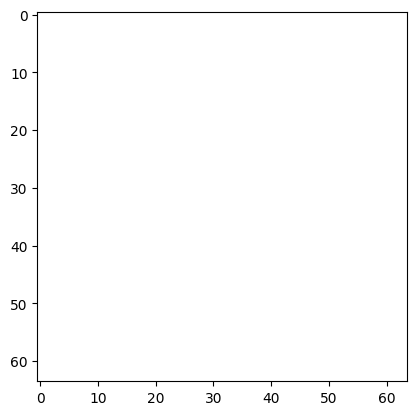

In [72]:
show_video(gt[2].cpu())

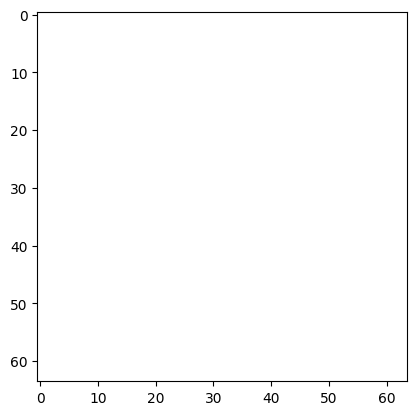

In [73]:
show_video(output[2].cpu().detach())

In [ ]:
show_video(batch[0][0].detach())
